## Nikshay Jain | MM21B044
### Assign 9

In [72]:
import numpy as np
import pandas as pd
from PIL import Image
import random, zipfile, cv2
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import Isomap, TSNE

### Extract & read data using pandas

In [82]:
train_df = pd.read_csv('./visual-taxonomy/train.csv')
test_df = pd.read_csv('./visual-taxonomy/test.csv')
samp_sub = pd.read_csv('./visual-taxonomy/sample_submission.csv')
cat_attr = pd.read_parquet('./visual-taxonomy/category_attributes.parquet')

In [83]:
train_df

id             Category  len      attr_1   attr_2   attr_3  \
0          0          Men Tshirts    5     default    round  printed   
1          1          Men Tshirts    5  multicolor     polo    solid   
2          2          Men Tshirts    5     default     polo    solid   
3          3          Men Tshirts    5  multicolor     polo    solid   
4          4          Men Tshirts    5  multicolor     polo    solid   
...      ...                  ...  ...         ...      ...      ...   
70208  70374  Women Tops & Tunics   10  multicolor   fitted  regular   
70209  70375  Women Tops & Tunics   10      yellow  regular     crop   
70210  70376  Women Tops & Tunics   10      maroon   fitted     crop   
70211  70377  Women Tops & Tunics   10         NaN      NaN      NaN   
70212  70378  Women Tops & Tunics   10        pink     boxy     crop   

            attr_4         attr_5   attr_6      attr_7         attr_8  \
0          default  short sleeves      NaN         NaN            NaN   
1            solid  short sleeves      NaN         NaN            NaN   
2            solid  short sleeves      NaN         NaN            NaN   
3            solid  short sleeves      NaN         NaN            NaN   
4            solid  short sleeves      NaN         NaN            NaN   
...            ...            ...      ...         ...            ...   
70208  square neck         casual  printed     default  short sleeves   
70209   round neck         casual  default     default  short sleeves   
70210   round neck         casual    solid       solid  short sleeves   
70211         high            NaN      NaN         NaN  short sleeves   
70212       v-neck         casual  printed  typography  short sleeves   

                attr_9  attr_10  
0                  NaN      NaN  
1                  NaN      NaN  
2                  NaN      NaN  
3                  NaN      NaN  
4                  NaN      NaN  
...                ...      ...  
70208  regular sleeves  ruffles  
70209  regular sleeves  knitted  
70210  regular sleeves  knitted  
70211              NaN      NaN  
70212  regular sleeves      NaN  

[70213 rows x 13 columns]

In [59]:
test_df

Category
0              Men Tshirts
1              Men Tshirts
2              Men Tshirts
3              Men Tshirts
4              Men Tshirts
...                    ...
30200  Women Tops & Tunics
30201  Women Tops & Tunics
30202  Women Tops & Tunics
30203  Women Tops & Tunics
30204  Women Tops & Tunics

[30205 rows x 1 columns]

In [60]:
samp_sub

id             Category  len           attr_1         attr_2  \
0  47001        Women Tshirts    8           maroon        regular   
1  16431               Sarees   10  same as saree\n  temple border   
2  55700  Women Tops & Tunics   10            white         fitted   
3  15698               Sarees   10  same as saree\n           zari   
4  30330               Kurtis    9           yellow         a-line   

          attr_3      attr_4      attr_5         attr_6           attr_7  \
0           crop     printed  typography  short sleeves  regular sleeves   
1   small border       cream       party       jacquard     woven design   
2        regular  round neck      casual          solid            solid   
3   small border       white       party       jacquard   woven design\n   
4  knee length\n       daily         net        default            solid   

                  attr_8           attr_9  attr_10  
0                default               nu       nu  
1             zari woven     ethnic motif       no  
2          short sleeves  regular sleeves  knitted  
3             zari woven           floral       no  
4  three-quarter sleeves          regular       nu

#### List down all attributes

In [61]:
cat_attr

Category  No_of_attribute  \
0          Men Tshirts                5   
1               Sarees               10   
2               Kurtis                9   
3        Women Tshirts                8   
4  Women Tops & Tunics               10   

                                      Attribute_list  
0  [color, neck, pattern, print_or_pattern_type, ...  
1  [blouse_pattern, border, border_width, color, ...  
2  [color, fit_shape, length, occasion, ornamenta...  
3  [color, fit_shape, length, pattern, print_or_p...  
4  [color, fit_shape, length, neck_collar, ocassi...

In [62]:
for _ in range(5):
    print(f"{cat_attr['Category'][_]}: {cat_attr['Attribute_list'][_]} \n")

Men Tshirts: ['color' 'neck' 'pattern' 'print_or_pattern_type' 'sleeve_length'] 

Sarees: ['blouse_pattern' 'border' 'border_width' 'color' 'occasion'
 'ornamentation' 'pallu_details' 'pattern' 'print_or_pattern_type'
 'transparency'] 

Kurtis: ['color' 'fit_shape' 'length' 'occasion' 'ornamentation' 'pattern'
 'print_or_pattern_type' 'sleeve_length' 'sleeve_styling'] 

Women Tshirts: ['color' 'fit_shape' 'length' 'pattern' 'print_or_pattern_type'
 'sleeve_length' 'sleeve_styling' 'surface_styling'] 

Women Tops & Tunics: ['color' 'fit_shape' 'length' 'neck_collar' 'ocassion' 'pattern'
 'print_or_pattern_type' 'sleeve_length' 'sleeve_styling'
 'surface_styling'] 



# Task 1:

### Datapreprocessing

In [64]:
def fragment_dataset(df, column_name, values):
    if df.empty:
        return {}
    try:
        fragments = {}
        for value in values:
            fragments[value] = df[df[column_name] == value]
        return fragments
    except KeyError:
        print(f"Error: Column '{column_name}' not found in DataFrame.")
        return {}
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return {}

In [187]:
def get_random_rows_by_value(df, column_name, value, num_rows):

    if not isinstance(df, pd.DataFrame):
        print("Error: Input 'df' must be a pandas DataFrame.")
        return None
    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in DataFrame.")
        return None
    if not isinstance(num_rows, int) or num_rows <= 0 :
        print("Error: 'num_rows' must be a positive integer.")
        return None

    filtered_df = df[df[column_name] == value]
    if filtered_df.empty:
        print(f"No rows found with '{column_name}' equal to '{value}'.")
        return None

    num_rows = min(num_rows, len(filtered_df))  # Ensure we don't try to sample more rows than exist
    random_indices = random.sample(range(len(filtered_df)), num_rows)
    random_rows_df = filtered_df.iloc[random_indices]
    return random_rows_df

In [188]:
def get_pixel_array_cv2_grayscale(image_path, num_pixels):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale mode
        if img is None:
            print(f"Error: Could not open or read image at '{image_path}'")
            return None

        height, width = img.shape  # Get image dimensions (height and width)
        total_pixels = height * width

        num_pixels = min(num_pixels, total_pixels)  # Ensure num_pixels does not exceed image size

        # Generate random pixel indices
        pixel_indices = np.random.choice(total_pixels, num_pixels, replace=False)

        pixel_array = []
        for index in pixel_indices:
            row = index // width
            col = index % width
            pixel_array.append(img[row, col])

        return np.array(pixel_array)

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [199]:
def format_integer(integer_list):
    if not isinstance(integer_list, list):
        print("Error: Input must be a list.")
        return []

    formatted_strings = []
    for item in integer_list:
        if not isinstance(item, int):
            print("Error: All elements in the list must be integers.")
            return []
        formatted_strings.append(f"./visual-taxonomy/train_images/{item:06d}.jpg")
    return formatted_strings

In [200]:
model1 = Isomap(n_components=2)
model2 = TSNE(n_components=2, random_state = 42)

fragments = fragment_dataset(train_df, 'Category', ['Men Tshirts', 'Sarees', 'Kurtis', 'Women Tshirts', 'Women Tops & Tunics'])
fragments['Men Tshirts']

id     Category  len      attr_1 attr_2   attr_3   attr_4  \
0        0  Men Tshirts    5     default  round  printed  default   
1        1  Men Tshirts    5  multicolor   polo    solid    solid   
2        2  Men Tshirts    5     default   polo    solid    solid   
3        3  Men Tshirts    5  multicolor   polo    solid    solid   
4        4  Men Tshirts    5  multicolor   polo    solid    solid   
...    ...          ...  ...         ...    ...      ...      ...   
7262  7424  Men Tshirts    5         NaN    NaN  printed      NaN   
7263  7425  Men Tshirts    5         NaN  round      NaN      NaN   
7264  7426  Men Tshirts    5         NaN    NaN      NaN  default   
7265  7429  Men Tshirts    5         NaN    NaN      NaN  default   
7266  7430  Men Tshirts    5         NaN    NaN      NaN      NaN   

             attr_5 attr_6 attr_7 attr_8 attr_9 attr_10  
0     short sleeves    NaN    NaN    NaN    NaN     NaN  
1     short sleeves    NaN    NaN    NaN    NaN     NaN  
2     short sleeves    NaN    NaN    NaN    NaN     NaN  
3     short sleeves    NaN    NaN    NaN    NaN     NaN  
4     short sleeves    NaN    NaN    NaN    NaN     NaN  
...             ...    ...    ...    ...    ...     ...  
7262            NaN    NaN    NaN    NaN    NaN     NaN  
7263            NaN    NaN    NaN    NaN    NaN     NaN  
7264  short sleeves    NaN    NaN    NaN    NaN     NaN  
7265            NaN    NaN    NaN    NaN    NaN     NaN  
7266  short sleeves    NaN    NaN    NaN    NaN     NaN  

[7267 rows x 13 columns]

# Task 2 and 3:

In [202]:
# Function to create image annotations with larger images
def place_images(ax, x, y, img_path, target_size=(48, 48)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img)
    ab = AnnotationBbox(OffsetImage(img), (x, y), frameon=False, pad=0.0)
    ax.add_artist(ab)

In [217]:
def execute(df, attr, value, n=100):
    l = []
    lid = get_random_rows_by_value(df, attr, value, n)

    temp_list = lid['id'].astype(int).tolist()
    path_list = format_integer(temp_list)
    for pth in path_list:
        temp = get_pixel_array_cv2_grayscale(pth, 256)
        l.append(temp)

    l_model1 = model1.fit_transform(l)

    l_arr = np.array(l)
    l_model2 = model2.fit_transform(l_arr)
    
    image_paths = path_list

    # Plot for Model 1 (Isomap)
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    ax1.scatter(l_model1[:, 0], l_model1[:, 1])
    ax1.set_title('Model 1 - Isomap')

    # Add images to the first plot
    for i in range(len(image_paths)):
        img_path = image_paths[i]
        place_images(ax1, l_model1[i, 0], l_model1[i, 1], img_path)

    plt.show()

    # Plot for Model 2 (t-SNE)
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    ax2.scatter(l_model2[:, 0], l_model2[:, 1])
    ax2.set_title('Model 2 - t-SNE')

    # Add images to the second plot
    for i in range(len(image_paths)):
        img_path = image_paths[i]
        place_images(ax2, l_model2[i, 0], l_model2[i, 1], img_path)

    plt.show()

### Execute the functions for:

Category: 'Women Tops & Tunics',

Attribute: occasion

Value: casual

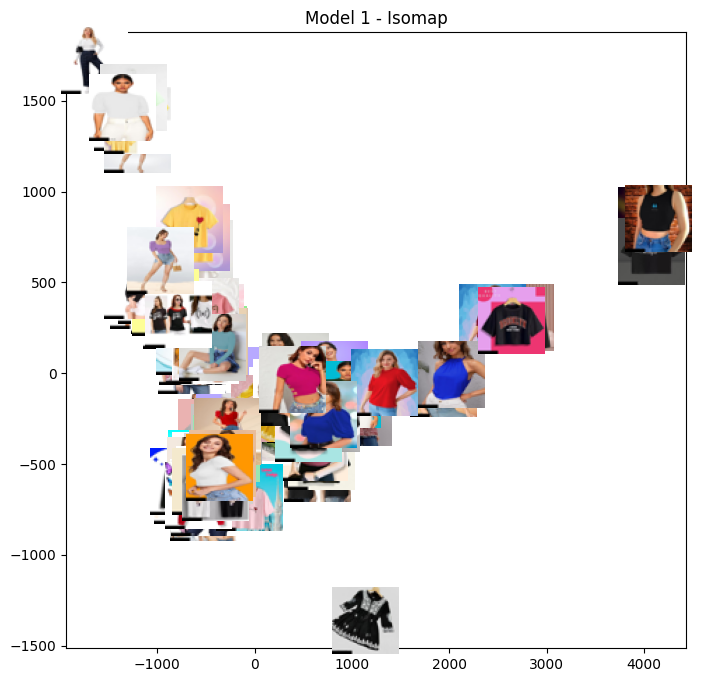

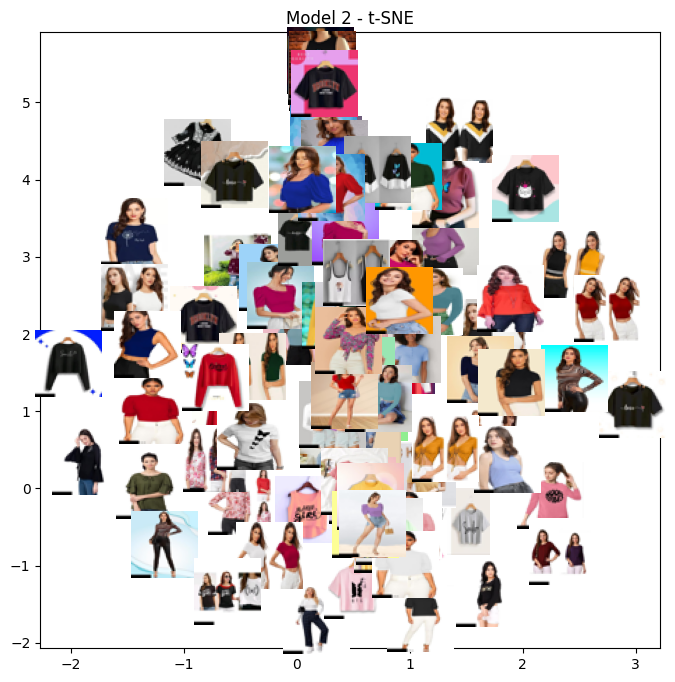

In [218]:
execute(fragments['Women Tops & Tunics'], 'attr_5', 'casual', 100)

Isomap:


tSNE:



### Execute the functions for:

Category: 'Women Tops & Tunics',

Attribute: sleeve_styling

Value: regular sleeves

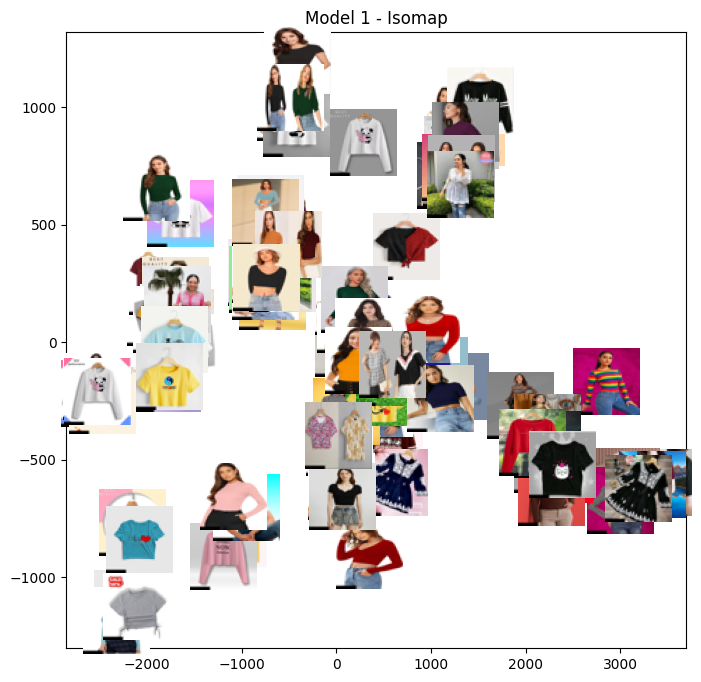

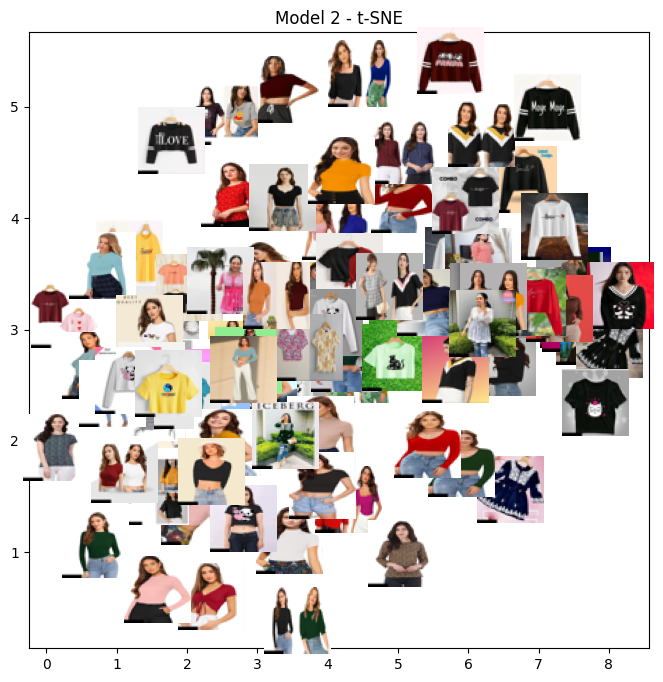

In [219]:
execute(fragments['Women Tops & Tunics'], 'attr_9', 'regular sleeves', 100)

Isomap:


tSNE:



### Execute the functions for:

Category: 'Women Tshirts',

Attribute: occasion

Value: typography

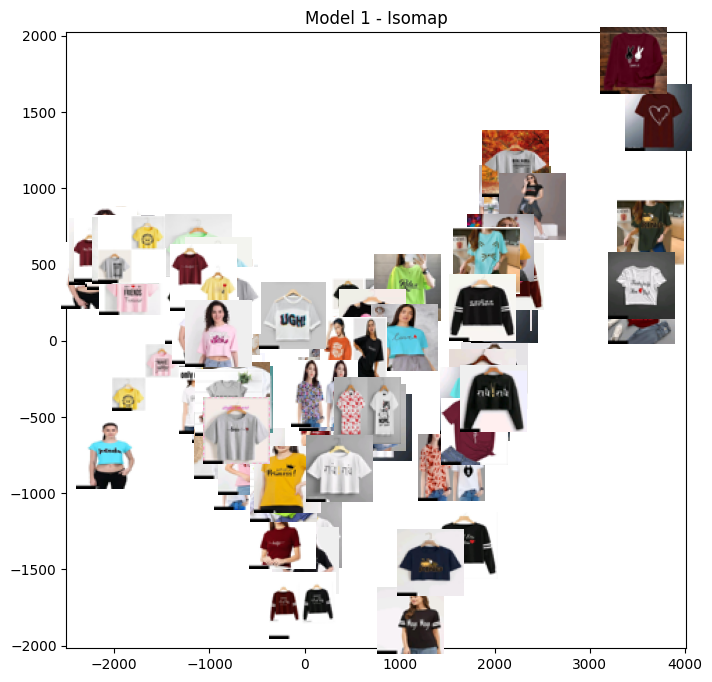

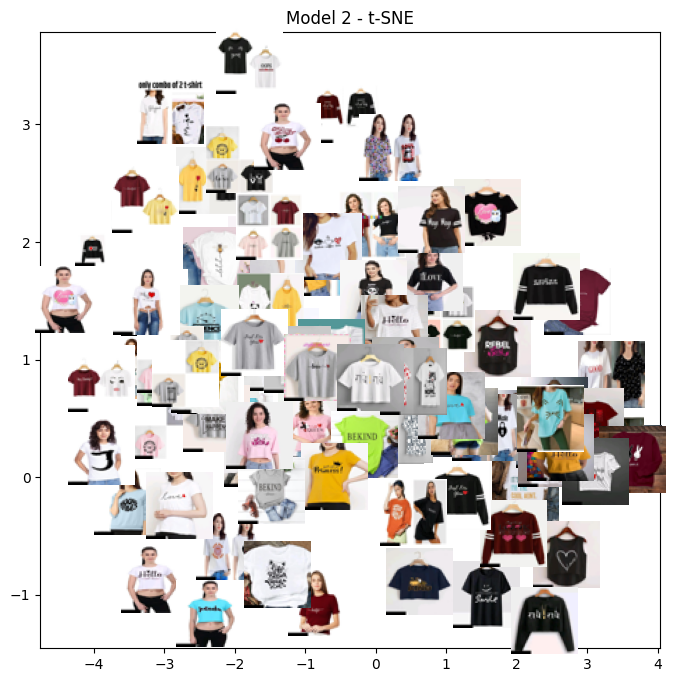

In [220]:
execute(fragments['Women Tshirts'], 'attr_5', 'typography', 100)

Isomap:


tSNE:



### Execute the functions for:

Category: 'Women Tshirts',

Attribute: print or pattern type

Value: regular sleeves

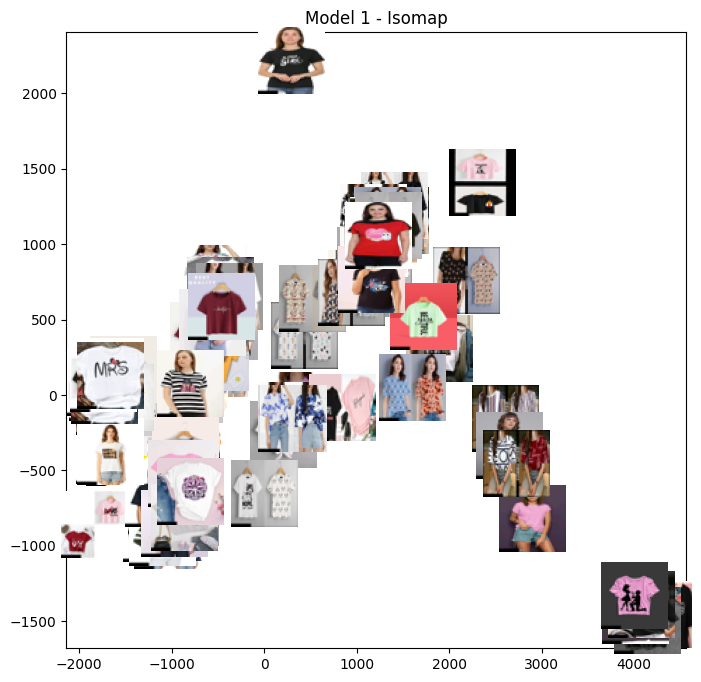

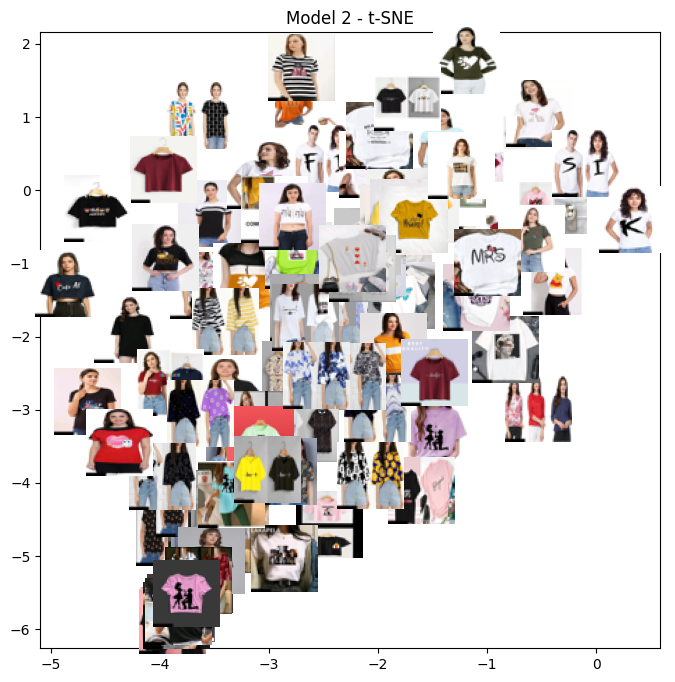

In [222]:
execute(fragments['Women Tshirts'], 'attr_7', 'regular sleeves', 100)

Isomap:


tSNE:



### Execute the functions for:

Category: 'Kurtis',

Attribute: length

Value: calf length

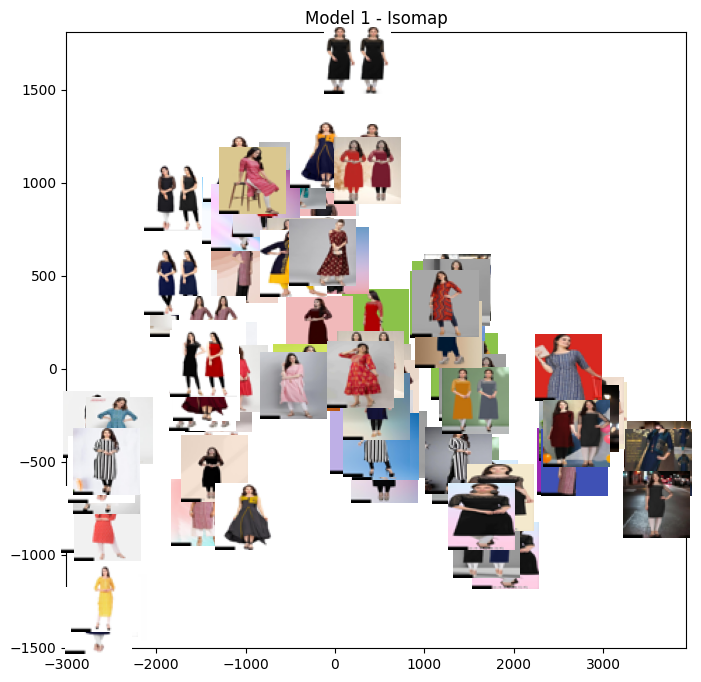

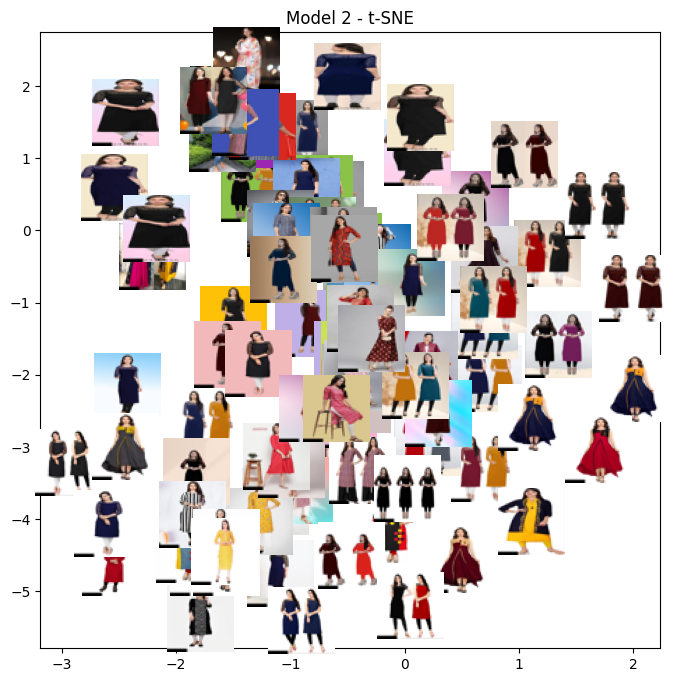

In [223]:
execute(fragments['Kurtis'], 'attr_3', 'calf length', 100)

Isomap:


tSNE:



### Execute the functions for:

Category: 'Kurtis',

Attribute: sleeve length

Value: regular

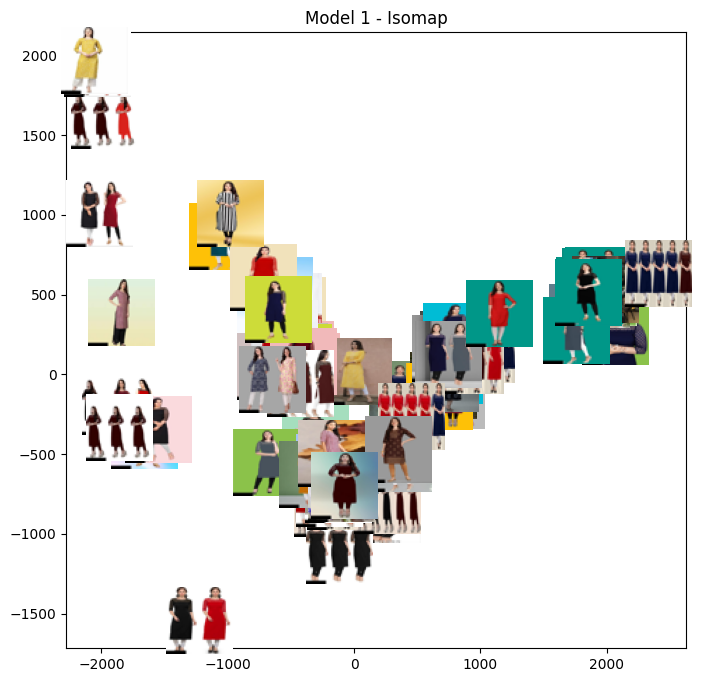

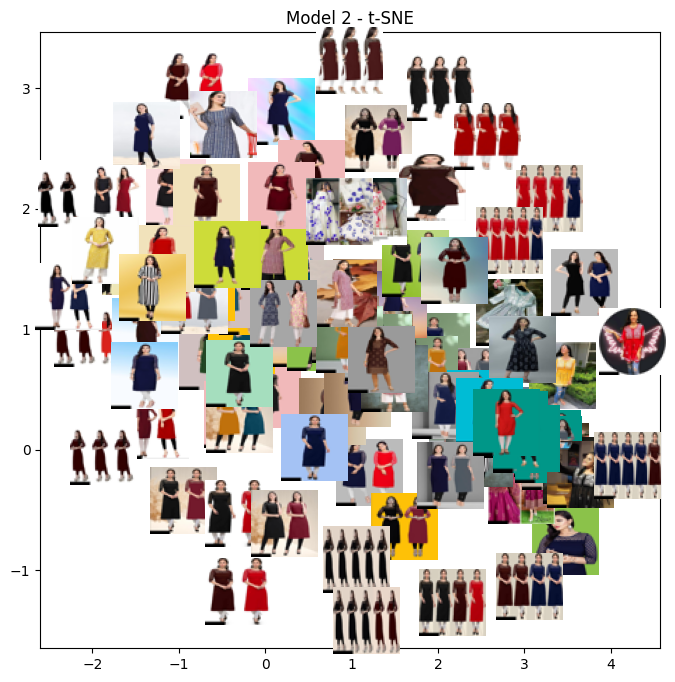

In [224]:
execute(fragments['Kurtis'], 'attr_9', 'regular', 100)

Isomap:


tSNE:



### Execute the functions for:

Category: 'Sarees',

Attribute: border_width

Value: small border

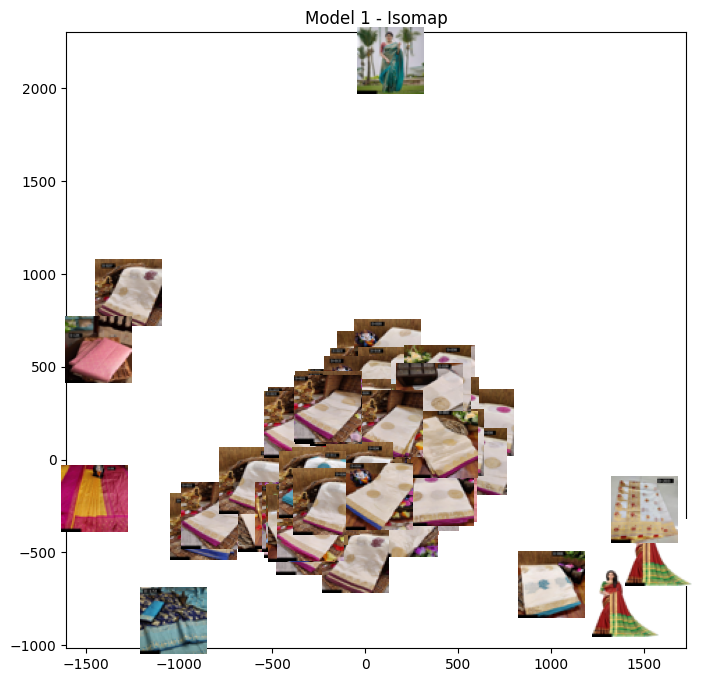

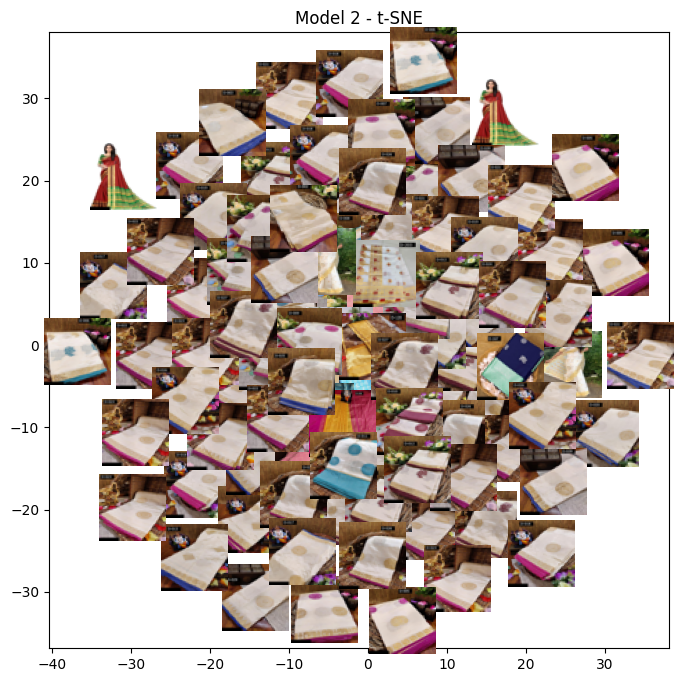

In [225]:
execute(fragments['Sarees'], 'attr_3', 'small border', 100)

Isomap:


tSNE:



### Execute the functions for:

Category: 'Sarees',

Attribute: occasion

Value: party

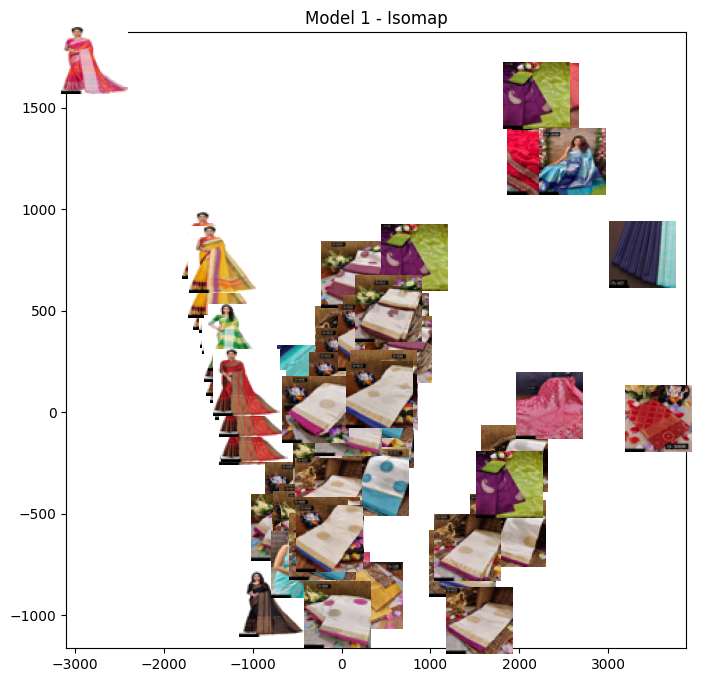

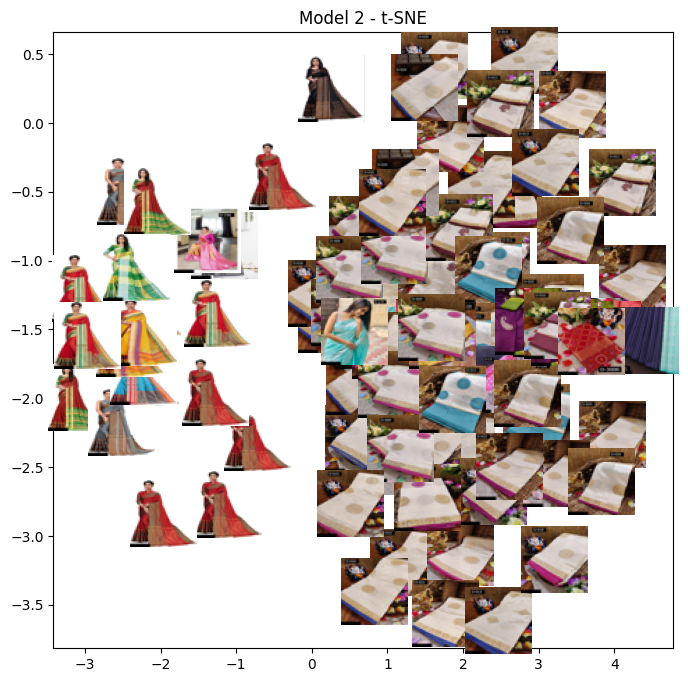

In [226]:
execute(fragments['Sarees'], 'attr_5', 'party', 100)

Isomap:


tSNE:



### Execute the functions for:

Category: 'Men Tshirts',

Attribute: neck

Value: polo

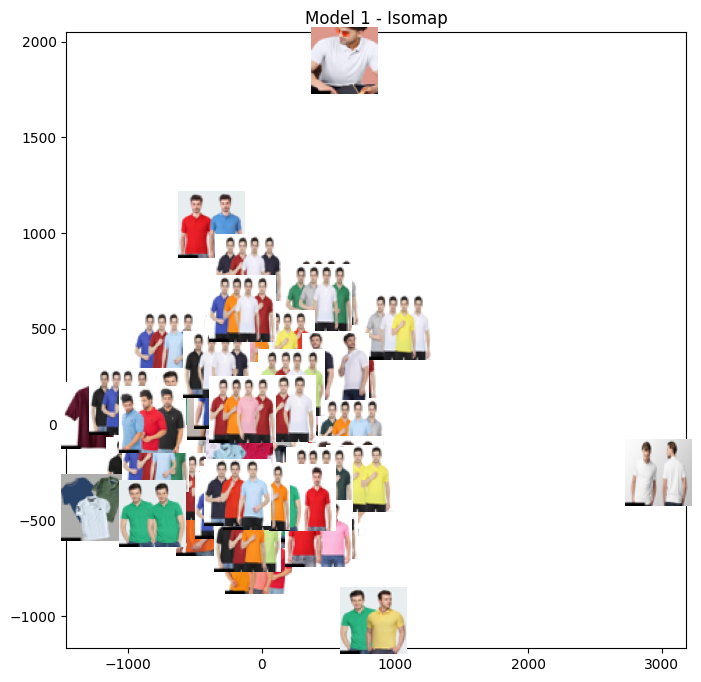

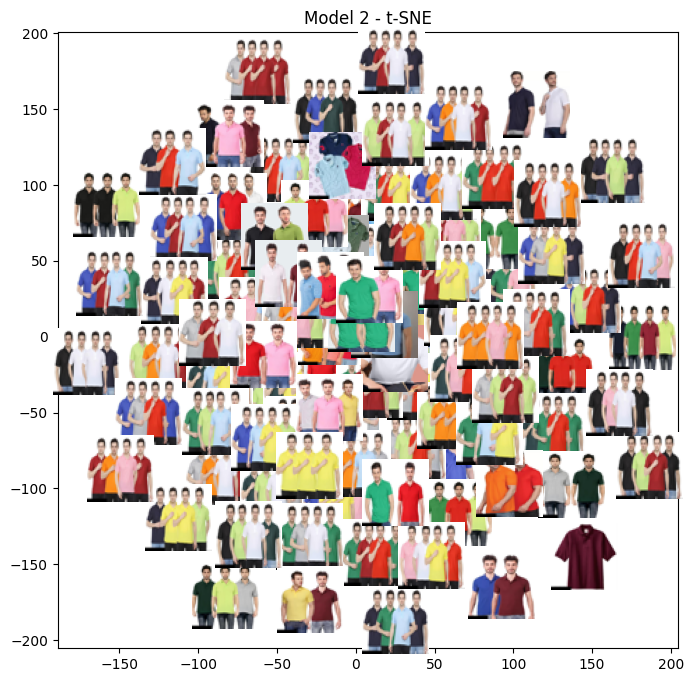

In [227]:
execute(fragments['Men Tshirts'], 'attr_2', 'polo', 100)

Isomap:


tSNE:



### Execute the functions for:

Category: 'Men Tshirts',

Attribute: sleeve_length

Value: short sleeves

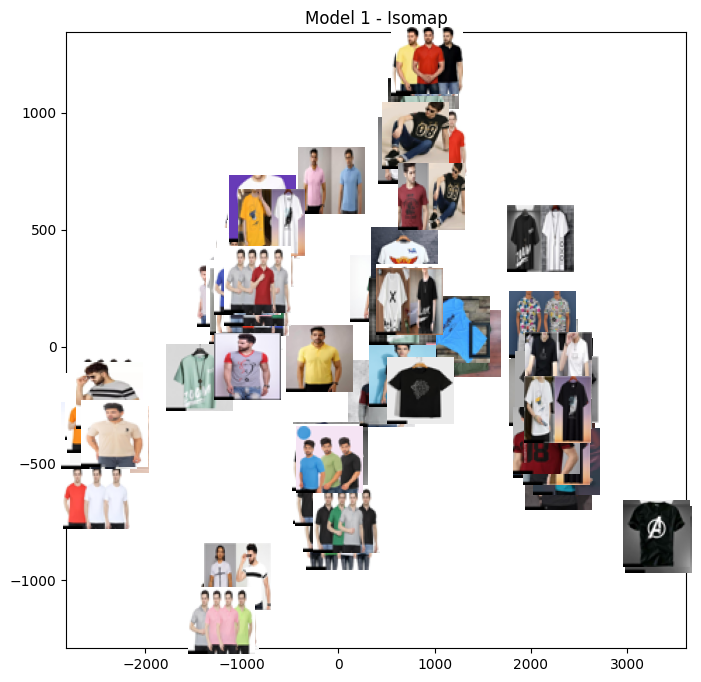

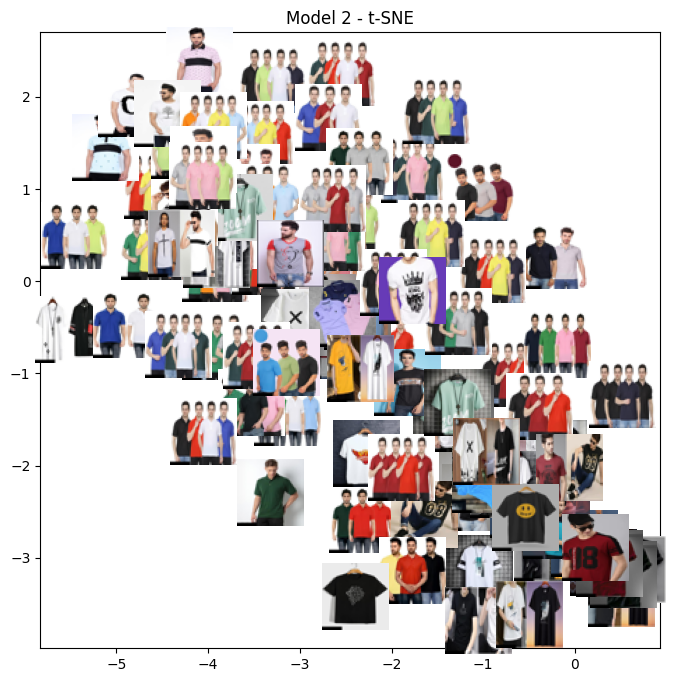

In [228]:
execute(fragments['Men Tshirts'], 'attr_5', 'short sleeves', 100)

Isomap:


tSNE:

